# 1. Load libraries, patient labels

In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import datetime

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 2. Functions to load CT scans, transform 'color', resize 3d image, save and load transformed images

In [2]:
# Load the scans in given folder path
def load_CT_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
def transform_into_hounsfield_units(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [4]:
def resample_size(image, scan, new_size = [64, 244, 244]):
    
    orig_size = image.shape # size [z,x,y] (x,y or y,x??)
    zoom = np.array(new_size, dtype=np.float32)/orig_size
    
    image = scipy.ndimage.interpolation.zoom(image, zoom, mode='nearest')
    
    return image

In [5]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [39]:
def plot_3d(image, threshold=-300, showB = True):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    if(showB == True):
        plt.show()
        
#     return fig

In [7]:
def save_image(image, fname, threshold = -200):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)

    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    fig.savefig(fname)
    plt.close()

# 3. Set directories, load patient labels

In [8]:
# Some constants 

data_root = '/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/'
# data_dir = data_root + 'sample_images/'
data_dir = data_root + 'stage1/'
patients = os.listdir(data_dir)
patients.remove('.DS_Store')

patients.sort()
labels_df = pd.read_csv(data_root + 'stage1_labels.csv', index_col=0)
labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


# 4. Check image 'color' distribution and image of a slice

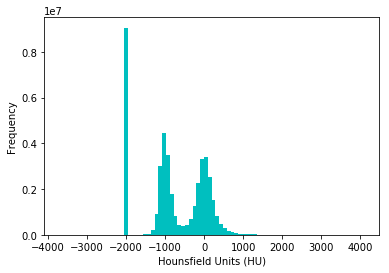

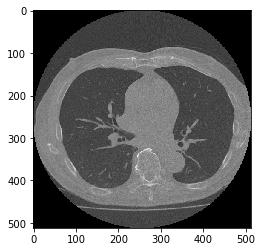

In [50]:
ct_scan = load_CT_scan(data_dir + patients[152])
ct_scan_image_HF = transform_into_hounsfield_units(ct_scan)
plt.hist(ct_scan_image_HF.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(ct_scan_image_HF[80], cmap=plt.cm.gray)
plt.show()

In [51]:
ct_scan_image_HF.shape

(161, 512, 512)

# 5. Load, transform, resize, save new images (multi-threaded)

In [11]:
# Single threaded code
# def fn(x):
#     ct_scan = load_CT_scan(data_dir + x)
#     ct_scan_image_HF = transform_into_hounsfield_units(ct_scan)
#     return resample_size(ct_scan_image_HF, ct_scan, [64, 244, 244])
# %time res = list(map(fn, patients[:2]))


CPU times: user 12.8 s, sys: 1.13 s, total: 13.9 s
Wall time: 14.4 s


In [11]:
image = res[0]
plt.hist(image.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(image[32], cmap=plt.cm.gray)
plt.show()

NameError: name 'res' is not defined

In [20]:
# Multi-threaded code; often works in Python 3.5
from multiprocessing import Pool
number_of_threads = 6
p = Pool(number_of_threads)

def fn(x):
    ct_scan = load_CT_scan(data_dir + x)
    ct_scan_image_HF = transform_into_hounsfield_units(ct_scan)
    return resample_size(ct_scan_image_HF, ct_scan, [64, 244, 244])
%time res = p.map(fn, patients)


/Users/szalmaf/anaconda/envs/kaggle2017/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/Users/szalmaf/anaconda/envs/kaggle2017/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/Users/szalmaf/anaconda/envs/kaggle2017/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/Users/szalmaf/anaconda/envs/kaggle2017/

CPU times: user 19.6 s, sys: 3min 1s, total: 3min 21s
Wall time: 40min 43s


In [ ]:
%time resArr = np.stack([arr for arr in res])

In [25]:
str(resArr.shape[0])

'1595'

In [26]:
file_name = data_root + 'images_3d_array-' + str(resArr.shape[0]) + 'x64x244x244.bc'
file_name

'/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/images_3d_array-1595x64x244x244.bc'

In [27]:
%time save_array(file_name, resArr)

CPU times: user 1min 1s, sys: 1min 8s, total: 2min 10s
Wall time: 2min 19s


# 6. Reload transformed images

In [9]:
resArr = load_array('/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/images_3d_array-1595x64x244x244.bc')

In [10]:
resArr.nbytes

12154869760

In [4]:
resArr10 = resArr[:10]

In [5]:
file_name = data_root + 'images_3d_array-' + str(resArr10.shape[0]) + 'x64x244x244.bc'
file_name

'/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/images_3d_array-10x64x244x244.bc'

In [6]:
%time save_array(file_name, resArr10)

CPU times: user 1.2 s, sys: 509 ms, total: 1.71 s
Wall time: 1.23 s


In [7]:
resArr100 = resArr[:100]

In [9]:
file_name = data_root + 'images_3d_array-' + str(resArr100.shape[0]) + 'x64x244x244.bc'
file_name

'/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/images_3d_array-100x64x244x244.bc'

In [10]:
%time save_array(file_name, resArr10)

CPU times: user 1.16 s, sys: 171 ms, total: 1.34 s
Wall time: 1.07 s


# 7. Reload transformed images

In [8]:
resArr10 = load_array('/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/images_3d_array-10x64x244x244.bc')

In [9]:
resArr10.shape

(10, 64, 244, 244)

# 8. Plot images and save in png

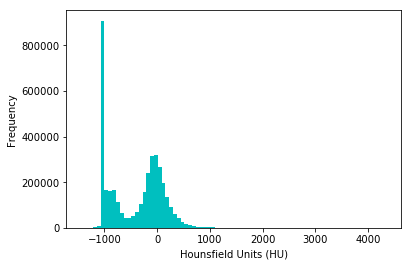

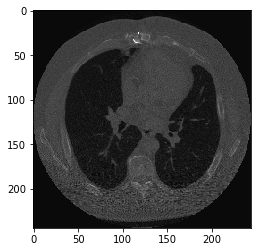

In [52]:
image3d = resArr[163]
plt.hist(image3d.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(image3d[32], cmap=plt.cm.gray)
plt.show()

In [48]:
patients[152]

'1a41350d4bbd74b7e0e28239cefa84c2'

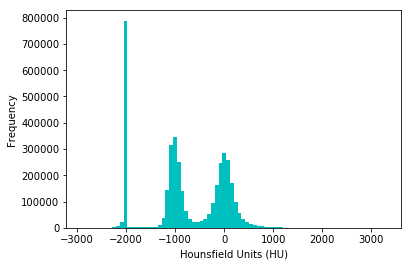

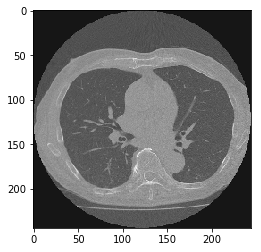

In [49]:
image3d = resArr[152]
plt.hist(image3d.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(image3d[32], cmap=plt.cm.gray)
plt.show()

In [12]:
resArr10.shape

(10, 64, 244, 244)

In [25]:
# Multi-threaded code; often works in Python 3.5
import multiprocessing as mp

def fn(x, i):
    save_image(x, "img" + str(i) + ".png", -200)
    return 1

def multiprocess(processes, n, dn):
    pool = mp.Pool(processes=processes)
    results = [pool.apply_async(fn, args=(x, i)) for i, x in enumerate(resArr[n:n+dn], n)]
    results = [p.get() for p in results]
    pool.close()
    return results

print(datetime.datetime.now())
dn = 3
for n in range(200, 206, dn):
    multiprocess(6, n, dn)
    print(datetime.datetime.now())

2017-02-26 09:30:15.160456
2017-02-26 09:31:00.467621
2017-02-26 09:31:52.363333


In [14]:
# Multi-threaded code; often works in Python 3.5
from multiprocessing import Pool
p = Pool(processes = 6)

def fn(x):
    save_image(x, "img25" + ".png", -200)
    
%time p.map(fn, resArr10)

CPU times: user 405 ms, sys: 423 ms, total: 828 ms
Wall time: 3min 3s


[None, None, None, None, None, None, None, None, None, None]

In [16]:
(image3d.min(), image3d.max())

(-1285, 3427)

In [34]:
image3d.ndim

3

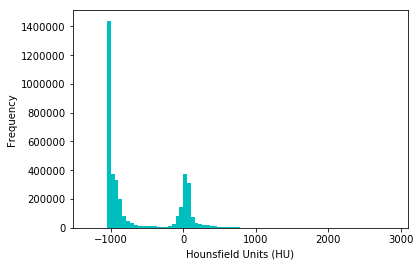

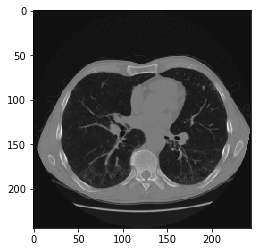

In [9]:
plt.hist(image3d.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(image3d[32], cmap=plt.cm.gray)
plt.show()

In [35]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [53]:
%time segmented_lungs = segment_lung_mask(resArr[162], False)

CPU times: user 531 ms, sys: 65.9 ms, total: 597 ms
Wall time: 592 ms


In [54]:
%time segmented_lungs_fill = segment_lung_mask(resArr[162], True)

CPU times: user 697 ms, sys: 49.8 ms, total: 747 ms
Wall time: 741 ms


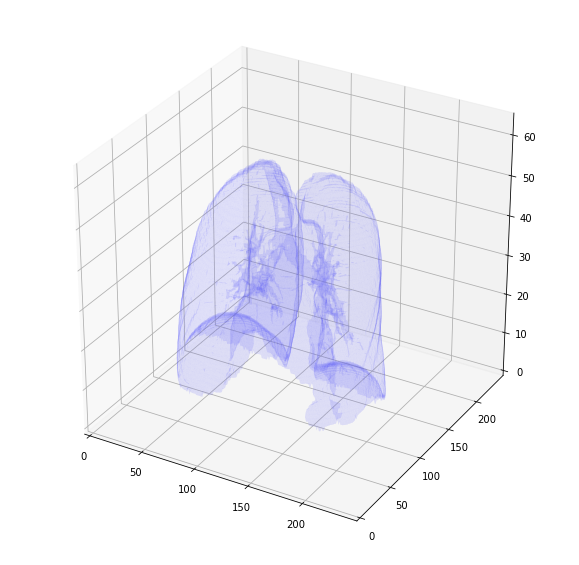

CPU times: user 21.4 s, sys: 1.43 s, total: 22.9 s
Wall time: 21 s


In [56]:
%time plot_3d(segmented_lungs, 0)

In [57]:
import gc

In [60]:
gc.collect()

0

In [59]:
resArr=1

In [61]:
resArr

1

In [25]:
np.uin (1000000000000000000000)

OverflowError: Python int too large to convert to C long